## 环境准备

如果在 binder hub 进行编译，只需要运行下面的命令即可保证程序正常运行：

```python
!pip install -U numpy
!pip install -U matplotlib
!pip install -U imageio
```

## 数据初步整理

### 获取 `./python/` 目录下的数据。

In [1]:
import os
import time
import numpy as np
import zipfile
import imageio
import pickle

%pylab inline


def timer(func):
    '''
    定义一个计时器，传入一个，并返回另一个附加了计时功能的方法
    '''

    # 定义一个内嵌的包装函数，给传入的函数加上计时功能的包装
    def wrapper(*args):
        start = time.time()
        func(*args)
        end = time.time()
        print('used: {:.4f} s'.format(end - start))

    # 将包装后的函数返回
    return wrapper


class Loader(dict):
    '''
    载入 zip 数据
    '''

    def __init__(self, data_path, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.__dict__ = self  # 使得该类成为一个 字典
        self.__Z = zipfile.ZipFile(data_path)  # 载入压缩文件
        self.get_names()

    def get_names(self):
        '''
        获取数据集集的 超类 名称
        '''
        names = []
        for name in self.__Z.NameToInfo:
            if name.count('/') == 3 and not name.endswith('/'):
                names.append(name)
        self.names = names

    def buffer2img(self, name):
        '''
        将 Buffer 形式的图片转换为 numpy
        '''
        img = imageio.imread(self.__Z.read(name))
        return img

    def imshow(self, name):
        '''
        显示灰度图
        '''
        img = self.buffer2img(name)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.show()

    def getCat(self):
        '''
        返回 cat_dict
        '''
        cat_dict = {}
        for name in self.names:
            _, alphabet, *_ = name.split('/')
            cat_dict.update({alphabet: {}})
        for name in self.names:
            _, alphabet, letter, _ = name.split('/')

            cat_dict[alphabet][letter] = cat_dict[alphabet].get(letter,
                                                                []) + [name]
        return cat_dict

    def stack_image(self):
        '''
        返回 Xs, ys， lang_dict

        =====
        Xs: 4 维数组，第一个维度表示子类，第二个维度表示样本
        ys: 样本的子类标签
        lang_dict：超类与子类的关系字典
        '''
        cat_dict = self.getCat()

        Xs = []
        ys = []
        lang_dict = {}
        curr_y = 0
        for alphabet in cat_dict:
            X = []
            lang_dict[alphabet] = [curr_y, None]
            for letter in cat_dict[alphabet]:
                names = cat_dict[alphabet][letter]
                X.append(np.stack([self.buffer2img(name) for name in names]))
                for _ in names:
                    ys.append(curr_y)
                lang_dict[alphabet][1] = curr_y
                curr_y += 1
            Xs.extend(np.stack(X))
        xs = np.stack(Xs)
        return xs, np.vstack(ys), lang_dict

    @timer
    def save(self, path):
        '''
        将整理好的数据保存到 path
        '''
        xs, _, c = self.stack_image()
        with open(path, "wb") as f:
            pickle.dump((xs, c), f)

    def __iter__(self):
        pass


train_path = './python/images_background.zip'
test_path = './python/images_evaluation.zip'
train_loader = Loader(train_path)
test_loader = Loader(test_path)

Populating the interactive namespace from numpy and matplotlib


In [2]:
train_loader.keys()

dict_keys(['_Loader__Z', 'names'])

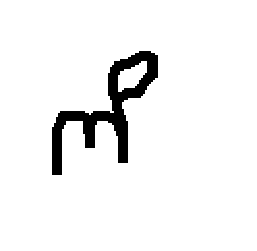

In [3]:
# 从测试集中随机选择一张图片，并显示
test_loader.imshow(test_loader.names[np.random.randint(len(test_loader.names))])

In [4]:
trainX, trainY, train_lang = train_loader.stack_image()
testX, testY, test_lang = test_loader.stack_image()

In [5]:
trainX.shape

(964, 20, 105, 105)

In [6]:
testX.shape

(659, 20, 105, 105)

In [7]:
character_num = trainX.shape[0] + testX.shape[0]
alphabet_num = len(train_lang) + len(test_lang)
print('Omniglot 数据集包含来自 {} 个不同字母的 {} 个字符。'.format(alphabet_num, character_num))
print('其中，训练集有 {} 个字母'.format(len(train_lang)), end=',')
print('测试集有 {} 个字母。'.format(len(test_lang)))
print('每一个字符都是由 {} 个不同的人通过亚马逊的 Mechanical Turk 在线绘制的。'.format(trainX.shape[1]))

Omniglot 数据集包含来自 50 个不同字母的 1623 个字符。
其中，训练集有 30 个字母,测试集有 20 个字母。
每一个字符都是由 20 个不同的人通过亚马逊的 Mechanical Turk 在线绘制的。


### 保存处理好的数据到 temp

In [7]:
temp = '../temp/'
if not os.path.exists(temp):
    os.mkdir(temp)

print('开始保存训练数据', end=', ')
train_loader.save('{}train.json'.format(temp))
print('开始保存测试数据', end=', ')
test_loader.save('{}test.json'.format(temp))

开始保存训练数据, used: 11.1990 s
开始保存测试数据, used: 8.4530 s
